In [1]:
import numpy as np
import pandas as pd

from project.dia_pckg.plot_style.cb91visuals import *
from project.part_2.BiddingEnvironment import BiddingEnvironment
from project.part_2.GPTS_Learner import GPTS_Learner
from project.part_2.Optimizer import *

In [2]:
np.random.seed(88)
n_obs = 100
# n_obs_exploration = round(n_obs*2/3)
# n_obs_exploitation = n_obs-n_obs_exploration
regret_threshold = 3000
n_subcamp = 3
max_bid = 1
max_clicks = 100
n_arms = 11

bids = np.linspace(0, max_bid, n_arms)
print(bids)

total_click_each_day = pd.DataFrame(columns=['bid_sub1', 'bid_sub2', 'bid_sub3',"click1","click2","click3"])

noise_std = 6.0
env = BiddingEnvironment(bids,max_clicks,noise_std)

learners = []
for i in range(0, n_subcamp):
    learners.append(GPTS_Learner(n_arms,bids))

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


# CLAIRVOYANT REWARD

In [3]:
all_optimal_subs = np.ndarray(shape=(0,len(bids)), dtype=float)
for i in range(0,n_subcamp):
    all_optimal_subs = np.append(all_optimal_subs,np.atleast_2d(env.subs[i](bids)),0)

print(all_optimal_subs)
print(fit_table(all_optimal_subs))
opt = fit_table(all_optimal_subs)[1]

[[  0.  33.  56.  70.  80.  87.  91.  94.  96.  98.  99.]
 [  0.  40.  64.  78.  87.  92.  96.  97.  99.  99. 100.]
 [  0.  51.  76.  88.  94.  97.  99. 100. 100. 100. 100.]]
([0.4, 0.3, 0.3], 246.0)


# EXPLORATION PHASE

In [4]:
n_obs_exploration = 0
daily_regret = 0

# for i in range(0, n_obs_exploration):
while (daily_regret < regret_threshold) and n_obs_exploration < round(n_obs*2/3):
    clicks = []
    n_obs_exploration = n_obs_exploration+1

    #Pull an arm for each sub-campaign:
    #It is pulled the arm belonging to the sub-campaign (i%3) which has the maximum variance
    #For the other 2 sub-campaigns the arm is pulled randomly (s.t. the sum = maximum)
    ### N.B. This behaviour works only for arms linearly distributed  over the array_bids
    first = i % 3
    pulled = [0,0,0]
    pulled[first] = learners[first].pull_arm()
    pulled[(first + 1 )% 3] = np.random.randint(0,n_arms - pulled[first])
    pulled[(first + 2 )% 3] = n_arms - pulled[first] - pulled[(first + 1 )% 3] - 1

    clicks = env.round(pulled[0],pulled[1],pulled[2])

    for x in range(0,n_subcamp):
        learners[x].update(pulled[x], clicks[x])
    total_click_each_day = total_click_each_day.append({
        'bid_sub1':pulled[0],
        'bid_sub2':pulled[1],
        'bid_sub3':pulled[2],
        "click1":clicks[0],
        "click2":clicks[1],
        "click3":clicks[2]
    }, ignore_index=True)

    reward = []
    for i in range(0,n_obs_exploration):
       num_clicks_day_i = total_click_each_day.values[i][3]  \
                       + total_click_each_day.values[i][4] \
                       + total_click_each_day.values[i][5]

       reward.append(num_clicks_day_i)

    daily_regret = np.sum(opt - reward)

In [5]:
print("lAST Regret: ", daily_regret)

print("Days used for exploration: ", n_obs_exploration)
n_obs_exploitation = n_obs - n_obs_exploration

lAST Regret:  3057.0
Days used for exploration:  49


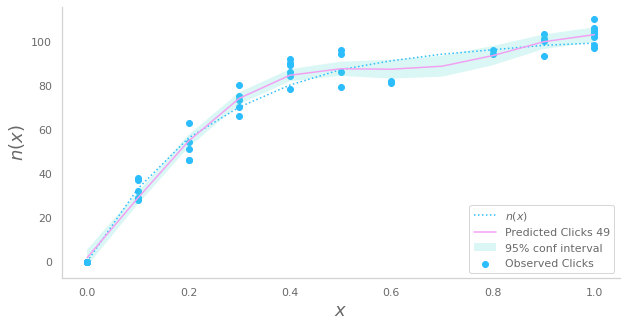

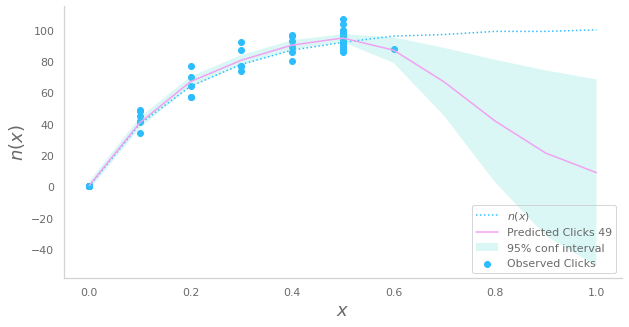

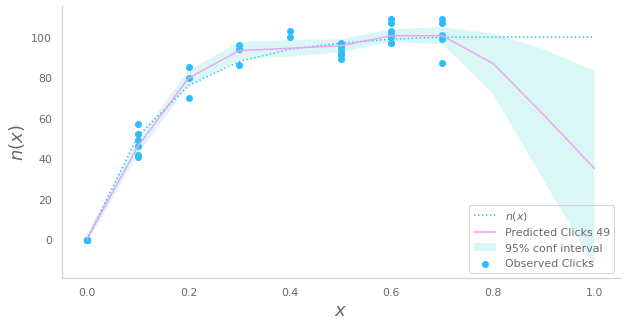

In [6]:
for s in range(0,n_subcamp):
    learners[s].plot(env.subs[s])

In [7]:
table_all_Subs = np.ndarray(shape=(0,len(bids)), dtype=float)
for l in learners:
    table_all_Subs = np.append(table_all_Subs,np.atleast_2d(l.means.T),0)

print(table_all_Subs)
print(fit_table(table_all_Subs))

[[  1.72867713  28.77123007  54.58917686  73.98572348  84.45114186
   87.37767048  87.1846303   88.54199044  93.35816667  99.61350646
  102.85201537]
 [  0.61284754  40.77511864  66.96409153  80.61912759  90.24712022
   94.75813204  87.05192565  66.68741937  41.81315297  21.32649509
    8.82112891]
 [  0.43123421  45.98688155  79.7286804   93.34975925  94.4634214
   95.75792097 100.67438518 100.70110139  87.01046584  61.66425729
   35.14862686]]
([0.4, 0.3, 0.3], 258.42002869729805)


# EXPLOITATION PHASE

In [8]:
for i in range(0, n_obs_exploitation):
    clicks = []

    pulled = fit_table(table_all_Subs)[0]

    clicks = env.round(pulled[0],pulled[1],pulled[2])


    for x in range(0,n_subcamp):
        learners[x].update(pulled[x], clicks[x])
    total_click_each_day = total_click_each_day.append({
        'bid_sub1':pulled[0],
        'bid_sub2':pulled[1],
        'bid_sub3':pulled[2],
        "click1":clicks[0],
        "click2":clicks[1],
        "click3":clicks[2]
    }, ignore_index=True)

    table_all_Subs = np.ndarray(shape=(0,len(bids)), dtype=float)
    for l in learners:
        table_all_Subs = np.append(table_all_Subs,np.atleast_2d(l.means.T),0)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
for s in range(0,n_subcamp):
    learners[s].plot(env.subs[s])

In [ ]:
print(fit_table(table_all_Subs))

## Regret Computation


In [ ]:
# list of the collected reward
rewards_per_experiment = []
opt = fit_table(all_optimal_subs)[1]
print(opt)

for i in range(0,n_obs):
    num_clicks_day_i = total_click_each_day.values[i][3]  \
                       + total_click_each_day.values[i][4] \
                       + total_click_each_day.values[i][5]
    rewards_per_experiment.append(num_clicks_day_i)

plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(opt - rewards_per_experiment, axis=0), 'r')
plt.show()

